In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from analysis import bender_class
from config import path_to_repository
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.model_selection import train_test_split
import matplotlib.ticker as mticker
from matplotlib.patches import Patch
import pandas as pd
import numpy as np
import os


In [3]:
import seaborn
seaborn.set(font='Arial',context='talk',font_scale=1.0, style='white')

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns

def make_figure1(
    figsize=(7, 10),
    wspace=0.40,
    hspace=0.55,
    left=0.10,
    right=0.98,
    top=0.98,
    bottom=0.08,
    label_fontsize=10,
    tick_fontsize=9,
    title_fontsize=11,
    panel_labels=("A", "B", "C", "D", "E"),
    panel_label_x=-0.18,
    panel_label_y=1.03,
    savepath=None,
    dpi=600,
    # these are callables you will define below
    plot_R_vs_strain=None,
    plot_raw_min_angle=None,
    plot_box_length=None,
    plot_reapply_abs_error=None,
    plot_misalignment_abs_error=None,
    # optional kwargs dicts forwarded to each plotting function
    R_vs_strain_kwargs=None,
    raw_min_kwargs=None,
    box_length_kwargs=None,
    reapply_kwargs=None,
    misalign_kwargs=None,
):
    """
    Build Figure 1 as a 4x2 seaborn/matplotlib layout.

    You must pass in plotting functions that actually draw each panel:
      - plot_R_vs_strain(ax, **R_vs_strain_kwargs)
      - plot_raw_min_angle(ax, **raw_min_kwargs)
      - plot_box_length(ax, **box_length_kwargs)
      - plot_reapply_abs_error(ax, **reapply_kwargs)
      - plot_misalignment_abs_error(ax, **misalign_kwargs)

    Those functions should NOT create or show figures; they should only draw
    into the provided `ax` and keep your original color choices.
    """

    # sane defaults for kwargs
    R_vs_strain_kwargs = R_vs_strain_kwargs or {}
    raw_min_kwargs = raw_min_kwargs or {}
    box_length_kwargs = box_length_kwargs or {}
    reapply_kwargs = reapply_kwargs or {}
    misalign_kwargs = misalign_kwargs or {}

    # global seaborn style for paper-quality plots
    sns.set_theme(style="white", context="paper")

    fig, axes = plt.subplots(4, 2, figsize=figsize)
    # Convenience indexing
    ax = axes

    # ------------------------------------------------------------------
    # PANEL POSITIONS (0-based indices):
    # Row 1, Col 2: R v strain (from model fitting notebook)  --> panel A
    # Row 2, Col 1: raw_plot_min_angle_100perc                --> panel B
    # Row 2, Col 2: box_plot_length                           --> panel C
    # Row 3, Col 2: reapplication abs angular error boxplot   --> panel D
    # Row 4, Col 2: misalignment abs angular error boxplot    --> panel E
    #
    # Other axes are turned off.
    # ------------------------------------------------------------------

    # Turn off unused axes (all col 1 except row 2)
    ax[0, 0].set_visible(False)
    ax[2, 0].set_visible(False)
    ax[3, 0].set_visible(False)

    # ---- A: R v strain (row 1, col 2) ----
    if plot_R_vs_strain is not None:
        plot_R_vs_strain(ax[0, 1], **R_vs_strain_kwargs)

    # ---- B: raw_plot_min_angle_100perc (row 2, col 1) ----
    if plot_raw_min_angle is not None:
        plot_raw_min_angle(ax[1, 0], **raw_min_kwargs)

    # ---- C: box_plot_length.pdf (row 2, col 2) ----
    if plot_box_length is not None:
        plot_box_length(ax[1, 1], **box_length_kwargs)

    # ---- D: reapplication abs angular error (left panel only) (row 3, col 2) ----
    if plot_reapply_abs_error is not None:
        plot_reapply_abs_error(ax[2, 1], **reapply_kwargs)

    # ---- E: misalignment abs angular error (left panel only) (row 4, col 2) ----
    if plot_misalignment_abs_error is not None:
        plot_misalignment_abs_error(ax[3, 1], **misalign_kwargs)

    # ---------------------------------------------------------
    # Global formatting: fonts and tick sizes
    # ---------------------------------------------------------
    for i_row in range(4):
        for j_col in range(2):
            a = ax[i_row, j_col]
            if not a.get_visible():
                continue
            # axis labels
            a.xaxis.label.set_size(label_fontsize)
            a.yaxis.label.set_size(label_fontsize)
            # tick labels
            a.tick_params(axis='both', which='major', labelsize=tick_fontsize)
            # title font
            if a.get_title():
                a.title.set_fontsize(title_fontsize)

    # ---------------------------------------------------------
    # Panel labels (A, B, C, D, E)
    # ---------------------------------------------------------
    # mapping from panel label index to axis
    label_axes = [
        ax[0, 1],  # A
        ax[1, 0],  # B
        ax[1, 1],  # C
        ax[2, 1],  # D
        ax[3, 1],  # E
    ]
    for lab, axis in zip(panel_labels, label_axes):
        axis.text(
            panel_label_x,
            panel_label_y,
            lab,
            transform=axis.transAxes,
            fontsize=label_fontsize,
            fontweight="bold",
            va="bottom",
            ha="right",
        )

    # Layout
    fig.subplots_adjust(
        left=left,
        right=right,
        top=top,
        bottom=bottom,
        wspace=wspace,
        hspace=hspace,
    )

    if savepath is not None:
        fig.savefig(savepath, dpi=dpi, bbox_inches="tight")
    return fig, axes


In [5]:
import os
import numpy as np
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt  # for consistency, even though we don't create figs here

def plot_R_vs_strain(ax):
    """
    Recreates the 'R v strain.pdf' panel on the provided axis `ax`.

    Uses:
      - DS1: 0.02 in x 0.02 in cross-section
      - DS2: 0.03 in x 0.03 in cross-section
      - DS3: 0.04 in x 0.04 in cross-section

    Assumes `path_to_repository` and `bender_class` are already defined.
    Keeps the original colors: black, gray, lightgray.
    """
    degree = 2  # retained for completeness, though not used directly

    # --- File paths ---
    DS1 = os.path.join(
        path_to_repository,
        "CSV Data/5_22_25/2.1_static_v1_silpoxy_5_22_25.csv"
    )  # 0.02 in x 0.02 in cross-section

    DS2 = os.path.join(
        path_to_repository,
        "CSV Data/6_6_25/2.1_static_v3_silpoxy_0.03_6_6_25.csv"
    )  # 0.03 in x 0.03 in cross-section

    DS3 = os.path.join(
        path_to_repository,
        "CSV Data/6_4_25/2.1_static_v2_silpoxy_0.04_6_4_25.csv"
    )  # 0.04 in x 0.04 in cross-section

    # ---------- 0.02 in x 0.02 in cross-section ----------
    g = bender_class()
    g.load_data(DS1)

    LSB = 31.25e-6  # 2*Vref/(ADC_Gain*2**16) [volts/bit]
    Gain = 831      # Opamp Gain

    # convert amplified adc value to un-amplified voltage so can compare to theoretical model
    g.data['ADC Value'] = (g.data['ADC Value'] * LSB + 2.048) / Gain
    g.normalize_adc_over_R0()

    thick = 0.115 + 0.25 + 0.125
    l_ch = 3.89
    l_sam = 2.1
    area = 0.017 * 0.017
    res = 0.4

    g.plot_mech_model_data(
        thick, l_ch, l_sam, area, res,
        scatter=False,
        data_color='black',
        model_color='black',
        data_label='0.02 in x 0.02 in',
        model_label='Model',
        normalize_by='over_R0',
        ax=ax,
    )

    # ---------- 0.03 in x 0.03 in cross-section ----------
    g = bender_class()
    g.load_data(DS2)

    LSB = 31.25e-6
    Gain = 481  # Gain lowered here to prevent clipping of ADC values

    # Multimeter does not have that resolution, starting resistance ~0.4–0.5 ohms
    g.data['ADC Value'] = (g.data['ADC Value'] * LSB + 2.048) / Gain
    g.normalize_adc_over_R0()

    thick = 0.23 + 0.25 + 0.125
    l_ch = 3.89
    l_sam = 1.9
    area = 0.027 * 0.027
    res = 0.4

    g.plot_mech_model_data(
        thick, l_ch, l_sam, area, res,
        scatter=False,
        data_color='gray',
        model_color='gray',
        data_label='0.03 in x 0.03 in',
        model_label='Model',
        normalize_by='over_R0',
        ax=ax,
    )

    # ---------- 0.04 in x 0.04 in cross-section ----------
    g = bender_class()
    g.load_data(DS3)

    LSB = 31.25e-6
    Gain = 831

    g.data['ADC Value'] = (g.data['ADC Value'] * LSB + 2.048) / Gain
    g.normalize_adc_over_R0()

    thick = 0.125 + 0.25 + 0.125
    l_ch = 3.89
    l_sam = 2.1
    area = 0.037 * 0.037
    res = 0.4

    g.plot_mech_model_data(
        thick, l_ch, l_sam, area, res,
        scatter=False,
        data_color='lightgray',
        model_color='lightgray',
        data_label='0.04 in x 0.04 in',
        model_label='Model',
        normalize_by='over_R0',
        ax=ax,
    )

    # ---------- axis labels & aesthetics ----------
    ax.set_xlabel("Estimated Strain (ε)")
    ax.set_ylabel(r"$\Delta R / R_0$")
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    #ax.legend(frameon=False)


In [6]:
def plot_raw_min_angle(ax):
    """
    Recreates 'raw_plot_min_angle_100perc.pdf' on the provided axis `ax`,
    with ADC values normalized to [0, 1].

    This version reloads the 0.04 in x 0.04 in dataset (DS3).
    Assumes `path_to_repository` and `bender_class` are already defined.
    """
    # --- load dataset (adjust if you used a different one in the notebook) ---
    DS3 = os.path.join(
        path_to_repository,
        "CSV Data/6_4_25/2.1_static_v2_silpoxy_0.04_6_4_25.csv"
    )

    g = bender_class()
    g.load_data(DS3)

    # If you were doing any ADC->voltage conversion before normalization
    # in the notebook, you can insert it here BEFORE the min-max step.

    # Extract data and drop NaNs
    x = g.data['Rotary Encoder'].to_numpy()
    adc_raw = g.data['ADC Value'].to_numpy()

    # --- Min-max normalize ADC to [0, 1] ---
    adc_min = np.nanmin(adc_raw)
    adc_max = np.nanmax(adc_raw)
    y = (adc_raw - adc_min) / (adc_max - adc_min)

    # Quadratic fit: y ≈ a*x^2 + b*x + c
    p = np.polyfit(x, y, 2)
    y_pred = np.polyval(p, x)
    r2 = r2_score(y, y_pred)

    # Smooth curve for plotting
    xs = np.linspace(x.min(), x.max(), 400)
    ys = np.polyval(p, xs)

    # Scatter (keep same style)
    ax.plot(
        x, y,
        color='black',
        linestyle='none',
        marker='.',
        markersize=5,
    )

    # Quadratic curve
    ax.plot(
        xs, ys,
        '--',
        color='black',
        linewidth=2,
        label=f'Quadratic fit (R² = {r2:.4f})',
    )

    # Labels
    ax.set_xlabel('Measured Bend angle (deg)')
    ax.set_ylabel(r'Normalized ADC MinMax 0$\rightarrow$1')

    # Legend without box
    ax.legend(frameon=False)

    # Clean aesthetics
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)


In [7]:
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker

def plot_box_length(
    ax,
    # layout knobs
    box_width=0.30,
    paired_offset=0.30,
    intra_group_spacing=0.80,
    gap_between_groups=1.40,
    # font knobs
    TITLE_FONTSIZE=18,
    LABEL_FONTSIZE=18,
    XTICK_FONTSIZE=16,
    YTICK_FONTSIZE=16,
):
    """
    Recreates the 'box_plot_length.pdf' panel on the provided axis `ax`.

    The layout knobs (box_width, paired_offset, intra_group_spacing, gap_between_groups)
    let you stretch/compress the boxes horizontally to make the plot look bigger.
    """

    degree = 2  # quadratic fit

    # -------------------- DATASET PATHS --------------------
    # 1.5 in samples
    DS25 = os.path.join(
        path_to_repository,
        "CSV Data/5_12_25/1.5_static_v2_velcro_5_12_25.csv"
    )

    # 1.7 in samples
    DS7_datafiles  = os.path.join(path_to_repository, "CSV Data/5_12_25/1.7_static_v1_velcro_5_12_25.csv")
    DS8_datafiles  = os.path.join(path_to_repository, "CSV Data/5_12_25/1.76_static_v2_velcro_5_12_25.csv")
    DS13_datafiles = os.path.join(path_to_repository, "CSV Data/5_12_25/1.73_static_v3_velcro_5_12_25.csv")
    DS14_datafiles = os.path.join(path_to_repository, "CSV Data/5_7_25/1.765_static_v1_velcro_5_7_25.csv")

    # 1.8 in samples
    DS3_datafiles = os.path.join(path_to_repository, "CSV Data/5_7_25/1.8_static_v1_velcro_5_7_25.csv")
    DS4_datafiles = os.path.join(path_to_repository, "CSV Data/4_22_25/1.86_static_v1_4_22_25.csv")
    DS6_datafiles = os.path.join(path_to_repository, "CSV Data/5_7_25/1.89_static_v2_velcro_5_7_25.csv")

    # 1.987 in samples
    DS16_datafiles = os.path.join(path_to_repository, "CSV Data/5_7_25/1.98_static_v2_velcro_5_7_25.csv")
    DS11_datafiles = os.path.join(path_to_repository, "CSV Data/5_7_25/1.987_static_v1_velcro_5_7_25.csv")

    # 2.3 in samples
    DS1_datafiles  = os.path.join(path_to_repository, "CSV Data/4_17_25/2.24_reapplication_v3_4_17_25.csv")
    DS2_datafiles  = os.path.join(path_to_repository, "CSV Data/4_18_25/2.27_reapplication_v2_4_18_25.csv")
    DS15_datafiles = os.path.join(path_to_repository, "CSV Data/4_18_25/2.34_static_v1_4_18_25.csv")

    DS_all = [
        [DS25],
        [DS7_datafiles, DS8_datafiles, DS13_datafiles, DS14_datafiles],
        [DS3_datafiles, DS4_datafiles, DS6_datafiles],
        [DS16_datafiles, DS11_datafiles],
        [DS1_datafiles, DS2_datafiles, DS15_datafiles],
    ]

    bar_labels = ["38.1 mm", "43.2 mm", "45.7 mm", "50.8 mm", "58.4 mm"]
    bar_colors = ["b"] * len(bar_labels)

    # -------------------- BUILD ERRORS --------------------
    group_errors = []

    for group in DS_all:
        group_errs = []
        for datafiles in group:
            g = bender_class()
            g.load_data(datafiles)
            g.normalize_adc_bw_01()
            g.train_model_test_accuracy(degree=degree)

            mean_error, std_error, predictions_df = g.cross_validation_angular_error(degree=degree)
            errs = predictions_df["Absolute Error"].dropna().tolist()
            group_errs.append(errs)

        group_errors.append(group_errs)

    # -------------------- POSITIONS (using tunable spacing) --------------------
    positions_left = []
    xticks_group   = []

    x_cursor = 1.0
    for group_errs in group_errors:
        n = len(group_errs)
        centers = list(x_cursor + np.arange(n) * intra_group_spacing)
        xticks_group.append(float(np.mean(centers)))
        positions_left.extend([c - paired_offset/2 for c in centers])
        x_cursor = centers[-1] + gap_between_groups + intra_group_spacing

    flat_errs = [errs for group in group_errors for errs in group]

    colors_for_boxes = []
    for gi, group_errs in enumerate(group_errors):
        colors_for_boxes.extend([bar_colors[gi]] * len(group_errs))

    # -------------------- PLOT ON GIVEN AXIS --------------------
    bp = ax.boxplot(
        flat_errs,
        positions=positions_left,
        widths=box_width,
        patch_artist=True,
        showfliers=False,
        medianprops={"color": "k", "linewidth": 1.6},
    )

    for patch, c in zip(bp['boxes'], colors_for_boxes):
        patch.set_facecolor(c)
        patch.set_alpha(0.9)

    # X ticks and labels at group centers
    ax.set_xticks(xticks_group)
    ax.set_xticklabels(bar_labels, fontsize=XTICK_FONTSIZE)
    ax.set_xlabel("Sensor Length Group (in)", fontsize=LABEL_FONTSIZE)
    ax.set_ylabel("Absolute Angular Error (deg)", fontsize=LABEL_FONTSIZE)
    ax.set_title("Absolute Angular Error of 13 Samples", fontsize=TITLE_FONTSIZE)

    # Style
    ax.tick_params(axis='x', labelsize=XTICK_FONTSIZE)
    ax.tick_params(axis='y', labelsize=YTICK_FONTSIZE)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    # Y axis: fixed 0..9, ticks every 1
    ax.set_ylim(0, 9)
    ax.yaxis.set_major_locator(mticker.MultipleLocator(1.0))
    ax.yaxis.set_major_formatter(mticker.FormatStrFormatter('%d'))
    ax.yaxis.set_minor_locator(mticker.AutoMinorLocator(2))


In [8]:
import os
import numpy as np
from matplotlib.patches import Patch

def plot_reapply_abs_error(
    ax,
    # layout knobs (you can tweak these when calling make_figure1)
    box_width=0.26,
    paired_offset=0.32,
    intra_group_spacing=0.76,
    gap_between_groups=1.50,
    # font knobs
    TITLE_FONTSIZE=18,
    LABEL_FONTSIZE=18,
    XTICK_FONTSIZE=16,
    YTICK_FONTSIZE=16,
):
    """
    Recreates the LEFT panel of left_boxplots_and_right_pairwise_method.pdf
    on the provided axis `ax`.

    Shows self-trained vs Model-1 cross absolute angular error for
    reapplication samples (1.86, 2.24, 2.34 groups).

    Only the LEFT boxplot panel is drawn (no right comparison plot).
    """

    degree = 2  # quadratic fit, as before

    # ------------------------------------------------------------
    # DATASET PATHS (reapplication sets)
    # ------------------------------------------------------------
    # 1.86 reapply sample
    DS1_datafiles = os.path.join(path_to_repository, "CSV Data/4_22_25/1.86_static_v1_4_22_25.csv")
    DS2_datafiles = os.path.join(path_to_repository, "CSV Data/4_22_25/1.86_reapplication_v1_4_22_25.csv")
    DS3_datafiles = os.path.join(path_to_repository, "CSV Data/4_22_25/1.86_reapplication_v2_4_22_25.csv")

    # 2.24 reapply sample
    DS4_datafiles = os.path.join(path_to_repository, "CSV Data/4_17_25/2.24_reapplication_v2_4_17_25.csv")
    DS5_datafiles = os.path.join(path_to_repository, "CSV Data/4_17_25/2.24_reapplication_v3_4_17_25.csv")
    DS6_datafiles = os.path.join(path_to_repository, "CSV Data/4_17_25/2.24_reapplication_v4_4_17_25.csv")

    # 2.34 reapply sample
    DS7_datafiles = os.path.join(path_to_repository, "CSV Data/4_18_25/2.34_static_v1_4_18_25.csv")
    DS8_datafiles = os.path.join(path_to_repository, "CSV Data/4_18_25/2.34_reapplication_v1_4_18_25.csv")
    DS9_datafiles = os.path.join(path_to_repository, "CSV Data/4_18_25/2.34_reapplication_v2_4_18_25.csv")

    # Grouped dataset list (same as DS_all in your code)
    DS_all = [
        [DS1_datafiles, DS2_datafiles, DS3_datafiles],
        [DS4_datafiles, DS5_datafiles, DS6_datafiles],
        [DS7_datafiles, DS8_datafiles, DS9_datafiles],
    ]

    bar_labels = ["47.2 mm", "56.9 mm", "59.4 mm"]
    bar_colors = ["b"] * len(bar_labels)

    # ------------------------------------------------------------
    # 1) SELF-TRAINED absolute error distributions
    # ------------------------------------------------------------
    group_errors = []  # per-group list of per-sample abs-error arrays

    for group in DS_all:
        group_errs = []

        for datafiles in group:
            g = bender_class()
            g.load_data(datafiles)
            g.normalize_adc_bw_01()
            g.train_model_test_accuracy(degree=degree)

            _, _, predictions_df = g.cross_validation_angular_error(degree=degree)
            errs = predictions_df["Absolute Error"].dropna().tolist()
            group_errs.append(errs)

        group_errors.append(group_errs)

    # ------------------------------------------------------------
    # 2) CROSS absolute error distributions (Model 1 → all)
    # ------------------------------------------------------------
    group_cross_errors = []

    for group in DS_all:
        # train Model 1 on the first sample in this group
        g_m1 = bender_class()
        g_m1.load_data(group[0])
        g_m1.normalize_adc_bw_01()
        g_m1.train_model_test_accuracy(perc_train=0.99, niter=1, degree=degree)

        group_cross = []

        for test_file in group:
            g_test = bender_class()
            g_test.load_data(test_file)
            g_test.normalize_adc_bw_01()
            df_test = g_test.data

            abs_errs = []
            # vary random_state to get distribution
            for rs in range(10):
                _, X_test = train_test_split(df_test, test_size=0.2, shuffle=True, random_state=rs)
                acc, abs_error = g_m1.predict_new_data(X_test)
                abs_errs.extend(np.asarray(abs_error).ravel())

            group_cross.append(abs_errs)

        group_cross_errors.append(group_cross)

    # ------------------------------------------------------------
    # 3) POSITIONS & COLORS (paired blue/red boxes per sample)
    # ------------------------------------------------------------
    positions        = []  # sample centers
    positions_self   = []  # x for self-trained (blue)
    positions_cross  = []  # x for cross (red)
    colors_for_boxes = []
    xticks_group     = []

    if len(bar_colors) != len(bar_labels):
        bar_colors = ["b"] * len(bar_labels)

    x_cursor = 1.0
    for (group_errs, lbl, group_color) in zip(group_errors, bar_labels, bar_colors):
        n = len(group_errs)
        centers = list(x_cursor + np.arange(n) * intra_group_spacing)
        positions.extend(centers)
        xticks_group.append(np.mean(centers))

        positions_self.extend([x - paired_offset/2 for x in centers])
        positions_cross.extend([x + paired_offset/2 for x in centers])

        colors_for_boxes.extend([group_color] * n)
        x_cursor = centers[-1] + gap_between_groups + intra_group_spacing

    # Flatten errors in same order
    flat_errs_self = [errs for grp in group_errors for errs in grp]
    flat_errs_cross = [errs for grp in group_cross_errors for errs in grp]

    # ------------------------------------------------------------
    # 4) PLOT on the provided axis (LEFT PANEL ONLY)
    # ------------------------------------------------------------
    bp_self = ax.boxplot(
        flat_errs_self,
        positions=positions_self,
        widths=box_width,
        patch_artist=True,
        showfliers=False,
        medianprops={"color": "k", "linewidth": 1.2},
    )

    bp_cross = ax.boxplot(
        flat_errs_cross,
        positions=positions_cross,
        widths=box_width,
        patch_artist=True,
        showfliers=False,
        medianprops={"color": "k", "linewidth": 1.2},
    )

    # Color boxes
    for patch, c in zip(bp_self['boxes'], colors_for_boxes):
        patch.set_facecolor(c)
        patch.set_alpha(0.9)

    for patch in bp_cross['boxes']:
        patch.set_facecolor('red')
        patch.set_alpha(0.7)

    # Labels & aesthetics
    ax.set_xticks(xticks_group)
    ax.set_xticklabels(bar_labels, fontsize=XTICK_FONTSIZE)
    ax.set_xlabel("Sensor Length (in)", fontsize=LABEL_FONTSIZE)
    ax.set_ylabel("Absolute Angular Error (deg)", fontsize=LABEL_FONTSIZE)
    ax.set_title("Reapplication Absolute Angular Error (3 Samples)", fontsize=TITLE_FONTSIZE)

    ax.tick_params(axis='x', labelsize=XTICK_FONTSIZE)
    ax.tick_params(axis='y', labelsize=YTICK_FONTSIZE)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    # Y axis: 0..9, ticks every 1°
    ax.set_ylim(0, 9)
    ax.yaxis.set_major_locator(mticker.MultipleLocator(1.0))
    ax.yaxis.set_major_formatter(mticker.FormatStrFormatter('%d'))
    ax.yaxis.set_minor_locator(mticker.AutoMinorLocator(2))

    # Legend (self vs Model 1)
    if bp_self['boxes'] and bp_cross['boxes']:
        self_color = bp_self['boxes'][0].get_facecolor()
        cross_color = bp_cross['boxes'][0].get_facecolor()
        ax.legend(
            handles=[
                Patch(facecolor=self_color,  label='Self-trained model'),
                Patch(facecolor=cross_color, label='Model 1'),
            ],
            frameon=False,
            fontsize=XTICK_FONTSIZE,
            loc='upper right',
        )


In [9]:
def plot_misalignment_abs_error(
    ax,
    # layout knobs
    box_width=0.26,
    paired_offset=0.32,
    intra_group_spacing=0.76,
    gap_between_groups=1.50,
    # font knobs
    TITLE_FONTSIZE=18,
    LABEL_FONTSIZE=18,
    XTICK_FONTSIZE=16,
    YTICK_FONTSIZE=16,
):
    """
    Recreates the LEFT panel of misalignment_left_boxplots_and_right_pairwise.pdf
    on the provided axis `ax`.

    Shows self-trained vs Model-1 cross absolute angular error for misalignment
    samples in three length groups (1.86, 2.24, 2.34).

    Only the LEFT boxplot panel is drawn (no right pairwise plot).
    """

    degree = 2  # quadratic fit, as in your notebook

    # =====================  DATASET PATHS  =====================
    # 1.86 group
    DS1_datafiles = os.path.join(path_to_repository, "CSV Data/4_22_25/1.86_static_v1_4_22_25.csv")
    DS2_datafiles = os.path.join(path_to_repository, "CSV Data/4_22_25/1.86_misalignment_v20_4_22_25.csv")
    DS3_datafiles = os.path.join(path_to_repository, "CSV Data/4_22_25/1.86_misalignment_v10_2nd_attempt_4_22_25.csv")

    # 2.24 group
    DS4_datafiles = os.path.join(path_to_repository, "CSV Data/4_17_25/2.24_reapplication_v3_4_17_25.csv")
    DS5_datafiles = os.path.join(path_to_repository, "CSV Data/4_17_25/2.24_misalignment_v10_4_17_25.csv")
    DS6_datafiles = os.path.join(path_to_repository, "CSV Data/4_17_25/2.24_misalignment_v20_4_17_25.csv")

    # 2.34 group
    DS7_datafiles = os.path.join(path_to_repository, "CSV Data/4_18_25/2.34_static_v1_4_18_25.csv")
    DS8_datafiles = os.path.join(path_to_repository, "CSV Data/4_18_25/2.34_misalignment_v10_4_18_25.csv")
    DS9_datafiles = os.path.join(path_to_repository, "CSV Data/4_18_25/2.34_misalignment_v20_4_18_25.csv")

    DS_all = [
        [DS1_datafiles, DS2_datafiles, DS3_datafiles],
        [DS4_datafiles, DS5_datafiles, DS6_datafiles],
        [DS7_datafiles, DS8_datafiles, DS9_datafiles],
    ]

    # Use mm labels (fixing the small typo "59.4 m" → "59.4 mm")
    bar_labels = ["47.2 mm", "56.9 mm", "59.4 mm"]
    bar_colors = ["b"] * len(bar_labels)

    # ================== 1) SELF-TRAINED ABS ERRORS ==================
    group_errors = []              # per-group list of per-sample abs-error arrays
    sample_labels_by_group = []    # not used for plotting, but kept for completeness
    ma100_self_list = []           # per-group list of per-sample min-angle dists (not plotted here)

    for group in DS_all:
        group_errs = []
        group_sample_labels = []
        group_ma100 = []

        for datafiles in group:
            g = bender_class()
            g.load_data(datafiles)
            g.normalize_adc_bw_01()
            g.train_model_test_accuracy(degree=degree)

            mean_error, std_error, predictions_df = g.cross_validation_angular_error(degree=degree)
            if not isinstance(predictions_df, pd.DataFrame):
                raise TypeError("cross_validation_angular_error must return a DataFrame")
            if "Absolute Error" not in predictions_df.columns:
                raise ValueError(f"{os.path.basename(datafiles)} missing 'Absolute Error' column")

            errs = predictions_df["Absolute Error"].dropna().tolist()
            group_errs.append(errs)

            # self min-angle distribution (not used for plotting here, but kept for consistency)
            _, ma100 = g.get_min_accuracy_100()
            group_ma100.append(np.asarray(ma100).ravel())

            group_sample_labels.append(os.path.splitext(os.path.basename(datafiles))[0])

        group_errors.append(group_errs)
        sample_labels_by_group.append(group_sample_labels)
        ma100_self_list.append(group_ma100)

    # ================== 2) CROSS ABS ERRORS (Model 1 → all) ==================
    group_cross_errors = []

    for group in DS_all:
        # train model on the FIRST sample of this group (model 1)
        g_m1 = bender_class()
        g_m1.load_data(group[0])
        g_m1.normalize_adc_bw_01()
        g_m1.train_model_test_accuracy(perc_train=0.99, niter=1, degree=degree)

        group_cross = []

        for test_file in group:
            g_test = bender_class()
            g_test.load_data(test_file)
            g_test.normalize_adc_bw_01()
            df_test = g_test.data

            acc_runs = []
            abs_errs = []
            for rs in range(10):
                _, X_test = train_test_split(df_test, test_size=0.2, shuffle=True, random_state=rs)
                acc, abs_error = g_m1.predict_new_data(X_test)
                acc_runs.append(np.asarray(acc))
                abs_errs.extend(np.asarray(abs_error).ravel())

            group_cross.append(abs_errs)

        group_cross_errors.append(group_cross)

    # ================== 3) POSITIONS & COLORS (paired boxes) ==================
    positions        = []  # sample centers (for reference)
    positions_self   = []  # x for blue boxes
    positions_cross  = []  # x for red boxes
    colors_for_boxes = []
    xticks_group     = []  # tick centers per group

    if len(bar_colors) != len(bar_labels):
        bar_colors = ["b"] * len(bar_labels)

    x_cursor = 1.0
    for gi, (group_errs, lbl, group_color) in enumerate(zip(group_errors, bar_labels, bar_colors)):
        n = len(group_errs)
        centers = list(x_cursor + np.arange(n) * intra_group_spacing)
        positions.extend(centers)
        xticks_group.append(np.mean(centers))

        positions_self.extend([x - paired_offset / 2 for x in centers])
        positions_cross.extend([x + paired_offset / 2 for x in centers])

        colors_for_boxes.extend([group_color] * n)
        x_cursor = centers[-1] + gap_between_groups + intra_group_spacing

    # Flatten self errors
    flat_errs_self = [errs for grp in group_errors for errs in grp]

    # Cross: **skip first sample in each group** (no red box on the base/“aligned” sample)
    flat_errs_cross_filtered = []
    positions_cross_filtered = []

    sample_idx = 0
    for gi, grp in enumerate(DS_all):
        for i in range(len(grp)):
            if i != 0:  # only misalignment samples get red boxes
                flat_errs_cross_filtered.append(group_cross_errors[gi][i])
                positions_cross_filtered.append(positions_cross[sample_idx])
            sample_idx += 1

    # ================== 4) PLOT ONLY THE LEFT PANEL ON ax ==================
    bp_self = ax.boxplot(
        flat_errs_self,
        positions=positions_self,
        widths=box_width,
        patch_artist=True,
        showfliers=False,
        medianprops={"color": "k", "linewidth": 1.2},
    )

    bp_cross = ax.boxplot(
        flat_errs_cross_filtered,
        positions=positions_cross_filtered,
        widths=box_width,
        patch_artist=True,
        showfliers=False,
        medianprops={"color": "k", "linewidth": 1.2},
    )

    # Color boxes
    for patch, c in zip(bp_self['boxes'], colors_for_boxes):
        patch.set_facecolor(c)
        patch.set_alpha(0.9)

    for patch in bp_cross['boxes']:
        patch.set_facecolor('red')
        patch.set_alpha(0.7)

    # Group ticks + axis labels
    ax.set_xticks(xticks_group)
    ax.set_xticklabels(bar_labels, fontsize=XTICK_FONTSIZE)
    ax.set_xlabel("Sensor Length (mm)", fontsize=LABEL_FONTSIZE)
    ax.set_ylabel("Absolute Angular Error (deg)", fontsize=LABEL_FONTSIZE)
    ax.set_title("Misalignment Absolute Angular Error (0°, 10°, 20°)", fontsize=TITLE_FONTSIZE)

    # Style
    ax.tick_params(axis='x', labelsize=XTICK_FONTSIZE)
    ax.tick_params(axis='y', labelsize=YTICK_FONTSIZE)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.grid(False)

    # Y axis: 0..9, ticks every 1°
    ax.set_ylim(0, 9)
    ax.yaxis.set_major_locator(mticker.MultipleLocator(1.0))
    ax.yaxis.set_major_formatter(mticker.FormatStrFormatter('%d'))
    ax.yaxis.set_minor_locator(mticker.AutoMinorLocator(2))

    # Legend (self vs Model 1)
    if bp_self['boxes'] and bp_cross['boxes']:
        self_color = bp_self['boxes'][0].get_facecolor()
        cross_color = bp_cross['boxes'][0].get_facecolor()
        ax.legend(
            handles=[
                Patch(facecolor=self_color,  label='Self-trained model'),
                Patch(facecolor=cross_color, label='Model 1'),
            ],
            frameon=False,
            fontsize=XTICK_FONTSIZE,
            loc='upper right',
        )


['C:/Users/toppe/OneDrive - CSU Maritime Academy/Documents/GitHub/Strain-Sensor-\\CSV Data/5_22_25/2.1_static_v1_silpoxy_5_22_25.csv']
ADC normalized with initial value R₀: 0.001814192238267148
['C:/Users/toppe/OneDrive - CSU Maritime Academy/Documents/GitHub/Strain-Sensor-\\CSV Data/6_6_25/2.1_static_v3_silpoxy_0.03_6_6_25.csv']
ADC normalized with initial value R₀: 0.00243587577962578
['C:/Users/toppe/OneDrive - CSU Maritime Academy/Documents/GitHub/Strain-Sensor-\\CSV Data/6_4_25/2.1_static_v2_silpoxy_0.04_6_4_25.csv']
ADC normalized with initial value R₀: 0.0020125977737665466
['C:/Users/toppe/OneDrive - CSU Maritime Academy/Documents/GitHub/Strain-Sensor-\\CSV Data/6_4_25/2.1_static_v2_silpoxy_0.04_6_4_25.csv']
['C:/Users/toppe/OneDrive - CSU Maritime Academy/Documents/GitHub/Strain-Sensor-\\CSV Data/5_12_25/1.5_static_v2_velcro_5_12_25.csv']
ADC normalized bw 0-1. ADC max:  1.0 ADC min:  0.0
['C:/Users/toppe/OneDrive - CSU Maritime Academy/Documents/GitHub/Strain-Sensor-\\CSV Dat

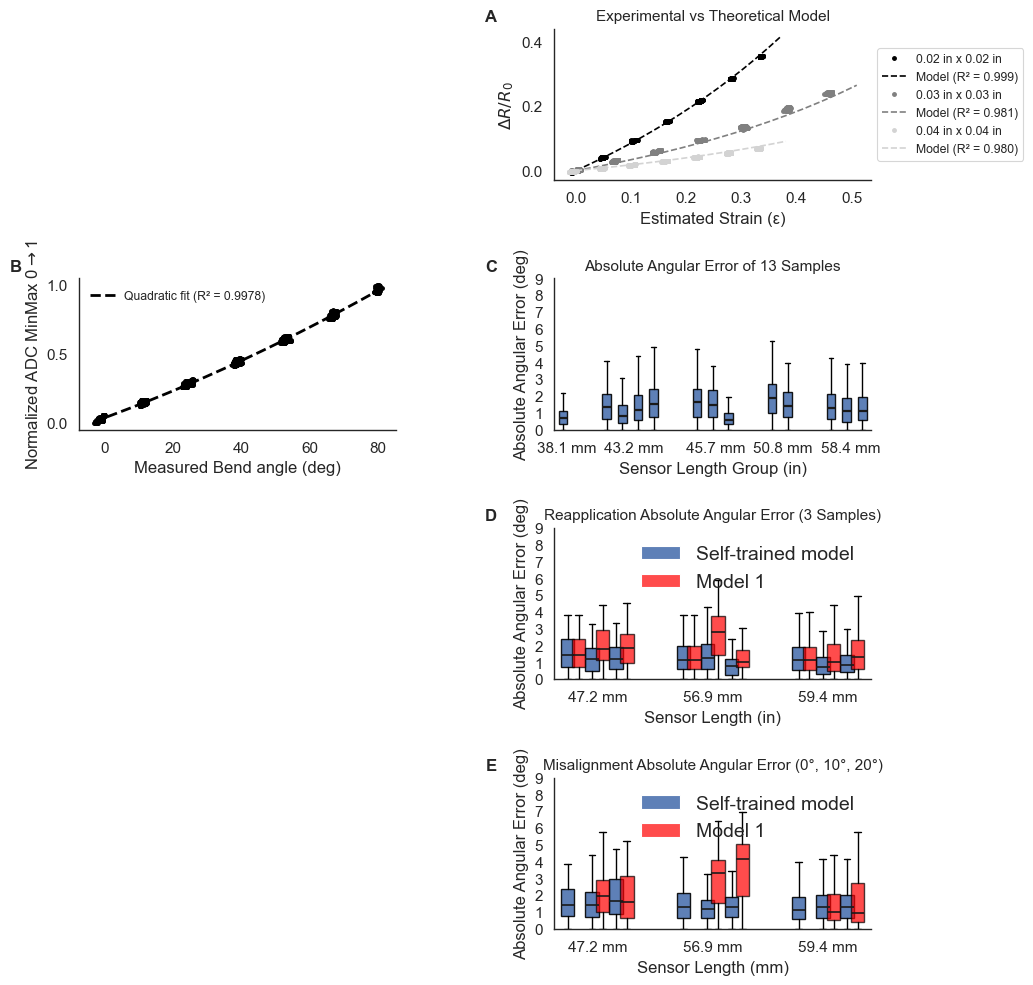

In [10]:
fig, axes = make_figure1(
    figsize=(9, 10),
    wspace=0.5,
    hspace=0.65,
    label_fontsize=12,
    tick_fontsize=11,
    title_fontsize=11,
    panel_labels=("A", "B", "C", "D", "E"),
    savepath="Figure1_full.pdf",
    plot_R_vs_strain=plot_R_vs_strain,               # row 1, col 2
    plot_raw_min_angle=plot_raw_min_angle,           # row 2, col 1
    plot_box_length=plot_box_length,                 # row 2, col 2
    plot_reapply_abs_error=plot_reapply_abs_error,   # row 3, col 2
    plot_misalignment_abs_error=plot_misalignment_abs_error,  # row 4, col 2
    box_length_kwargs=dict(
        box_width=0.50,
        paired_offset=0.40,
        intra_group_spacing=0.90,
        gap_between_groups=1.60,
        TITLE_FONTSIZE=18,
        LABEL_FONTSIZE=18,
        XTICK_FONTSIZE=14,
        YTICK_FONTSIZE=14,
    ),
    reapply_kwargs=dict(
        box_width=0.50,
        paired_offset=0.40,
        intra_group_spacing=0.90,
        gap_between_groups=1.60,
        TITLE_FONTSIZE=18,
        LABEL_FONTSIZE=18,
        XTICK_FONTSIZE=14,
        YTICK_FONTSIZE=14,
    ),
    misalign_kwargs=dict(
        box_width=0.50,
        paired_offset=0.40,
        intra_group_spacing=0.90,
        gap_between_groups=1.60,
        TITLE_FONTSIZE=18,
        LABEL_FONTSIZE=18,
        XTICK_FONTSIZE=14,
        YTICK_FONTSIZE=14,
    ),
)
